```
TODO: Model saver callback
TODO: Example image saver callback
```

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from glob import glob
from natsort import natsorted
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, RandomHorizontalFlip, Lambda
import torchvision.transforms.functional as TF
import pytorch_lightning as pl
from pytorch_lightning.logging import TestTubeLogger
from torchsummary import summary

from kitti_adapt.depth.data import VkittiImageDataset, KittiDepthDataset, mix_datasets
from kitti_adapt.depth.metrics import rmse_log, grad_loss, normal_loss, imgrad_yx
from kitti_adapt.depth.visualization import show_sample

# Define Model

In [4]:
# Architecture source: github.com/xanderchf/MonoDepth-FPN-PyTorch
def agg_node(in_planes, out_planes):
    return nn.Sequential(
        nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
    )

def smooth(in_planes, out_planes):
    return nn.Sequential(
        nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
    )

def predict(in_planes, out_planes):
    return nn.Sequential(
        nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1, padding=1),
        nn.Sigmoid(),
    )

def upshuffle(in_planes, out_planes, upscale_factor):
    return nn.Sequential(
        nn.Conv2d(in_planes, out_planes*upscale_factor**2, kernel_size=3, stride=1, padding=1),
        nn.PixelShuffle(upscale_factor),
        nn.ReLU()
    )

class DepthEstimator(pl.LightningModule):
    def __init__(self, learning_rate=1e-5, log_images_every_n_steps=1, log_train_loss_every_n_steps=10):
        super().__init__()
        self.learning_rate = learning_rate
        self.log_images_every_n_steps = log_images_every_n_steps
        self.log_train_loss_every_n_steps = log_train_loss_every_n_steps

        resnet = torchvision.models.resnet.resnet101(progress=True, pretrained=True)
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1 = nn.Sequential(resnet.layer1)
        self.layer2 = nn.Sequential(resnet.layer2)
        self.layer3 = nn.Sequential(resnet.layer3)
        self.layer4 = nn.Sequential(resnet.layer4)
        # Top layer
        self.toplayer = nn.Conv2d(2048, 256, kernel_size=1, stride=1, padding=0)  # Reduce channels
        # Lateral layers
        self.latlayer1 = nn.Conv2d(1024, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer2 = nn.Conv2d( 512, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer3 = nn.Conv2d( 256, 256, kernel_size=1, stride=1, padding=0)
        # Smooth layers
        self.smooth1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        # Aggregate layers
        self.agg1 = agg_node(256, 128)
        self.agg2 = agg_node(256, 128)
        self.agg3 = agg_node(256, 128)
        self.agg4 = agg_node(256, 128)
        # Upshuffle layers
        self.up1 = upshuffle(128,128,8)
        self.up2 = upshuffle(128,128,4)
        self.up3 = upshuffle(128,128,2)
        # Depth prediction
        self.predict1 = smooth(512, 128)
        self.predict2 = predict(128, 1)

    def _upsample_add(self, x, y):
        '''Upsample and add two feature maps.
        Args:
          x: (Variable) top feature map to be upsampled.
          y: (Variable) lateral feature map.
        Returns:
          (Variable) added feature map.
        Note in PyTorch, when input size is odd, the upsampled feature map
        with `F.upsample(..., scale_factor=2, mode='nearest')`
        maybe not equal to the lateral feature map size.
        e.g.
        original input size: [N,_,15,15] ->
        conv2d feature map size: [N,_,8,8] ->
        upsampled feature map size: [N,_,16,16]
        So we choose bilinear upsample which supports arbitrary output sizes.
        '''
        _,_,H,W = y.size()
        return F.interpolate(x, size=(H,W), mode='bilinear') + y

    def forward(self, x):
        # Bottom-up
        c1 = self.layer0(x)
        c2 = self.layer1(c1)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)
        # Top-down
        p5 = self.toplayer(c5)
        p4 = self._upsample_add(p5, self.latlayer1(c4))
        p4 = self.smooth1(p4)
        p3 = self._upsample_add(p4, self.latlayer2(c3))
        p3 = self.smooth2(p3)
        p2 = self._upsample_add(p3, self.latlayer3(c2))
        p2 = self.smooth3(p2)
        # Top-down predict and refine
        d5, d4, d3, d2 = self.up1(self.agg1(p5)), self.up2(self.agg2(p4)), self.up3(self.agg3(p3)), self.agg4(p2)
        _, _, H, W = d2.size()
        vol = torch.cat( [ F.interpolate(d, size=(H,W), mode='bilinear') for d in [d5,d4,d3,d2] ], dim=1 )        
        return self.predict2( self.predict1(vol) )     # img : depth = 4 : 1
    # =========================================
    # Vanilla PyTorch methods end here.
    # It's PyTorch Lightning from here on down.
    # =========================================

    def loss(self, pred, target):
        grad_pred, grad_target = imgrad_yx(pred), imgrad_yx(target)
        loss_grad = grad_loss(grad_pred, grad_target)
        loss_normal = normal_loss(grad_pred, grad_target)
        loss_depth = rmse_log(pred, target)
        return loss_depth + loss_grad + loss_normal

    def configure_optimizers(self):
        return [torch.optim.Adam(self.parameters(), lr=self.learning_rate)]

    def training_step(self, batch, batch_nb):
        rgb = batch["rgb"]
        depth = batch["depth"]
        pred = self.forward(rgb)
        loss = self.loss(pred, depth)
        output = {"loss": loss}
        if batch_nb % 100 == 0:
            output["log"] = {"train_loss": loss}
        return output

    def validation_step(self, batch, batch_nb):
        rgb = batch["rgb"]
        depth = batch["depth"]
        pred = self.forward(rgb)
        loss = self.loss(pred, depth)
        if batch_nb % self.log_images_every_n_steps == 0:
            pass
        return {"val_loss": loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        tensorboard_logs = {"val_loss": avg_loss}
        return {"avg_loss": avg_loss, "log": tensorboard_logs}

#     def test_step(self, batch, batch_nb):
#         return {"loss": 0}

testmodel = DepthEstimator()

# Dataset Transforms

In [3]:
# Define transforms
def train_transform(sample):
    rgb = sample["rgb"]
    depth = sample["depth"]
    flip = np.random.uniform(0.0, 1.0) < 0.5
    rgb_transform = Compose([
        Resize([192,640]),
        RandomHorizontalFlip(flip),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    depth_transform = Compose([
        Resize([48,160]),
        RandomHorizontalFlip(flip),
        ToTensor(),
        Lambda(lambda x: x.float() / 65535),
    ])
    return {"rgb": rgb_transform(rgb), "depth": depth_transform(depth)}

def val_transform(sample):
    rgb = sample["rgb"]
    depth = sample["depth"]
    rgb_transform = Compose([
        Resize([192,640]),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    depth_transform = Compose([
        Resize([48,160]),
        ToTensor(),
        Lambda(lambda x: x.float() / 65535),
    ])
    return {"rgb": rgb_transform(rgb), "depth": depth_transform(depth)}

# Instantiate Datasets

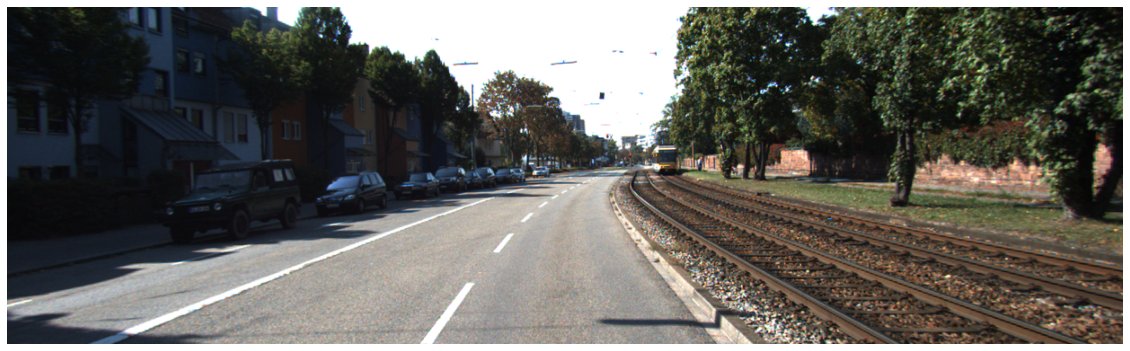

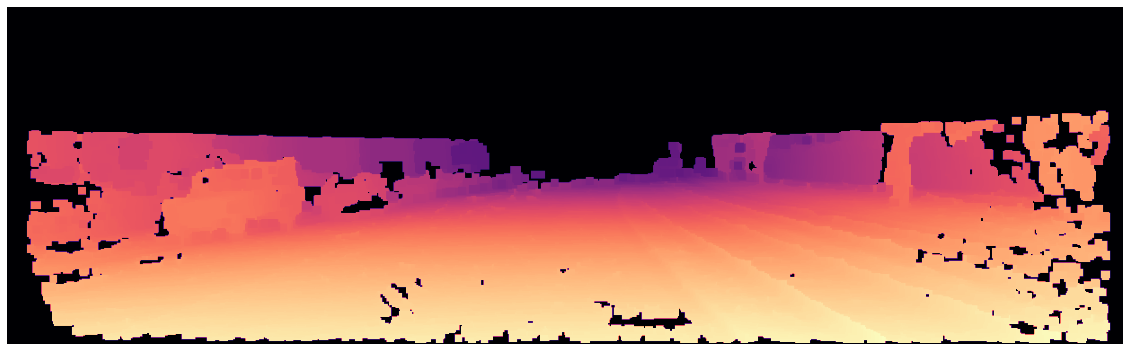

Dataset contains 10073 files.
Dataset contains 2682 files.


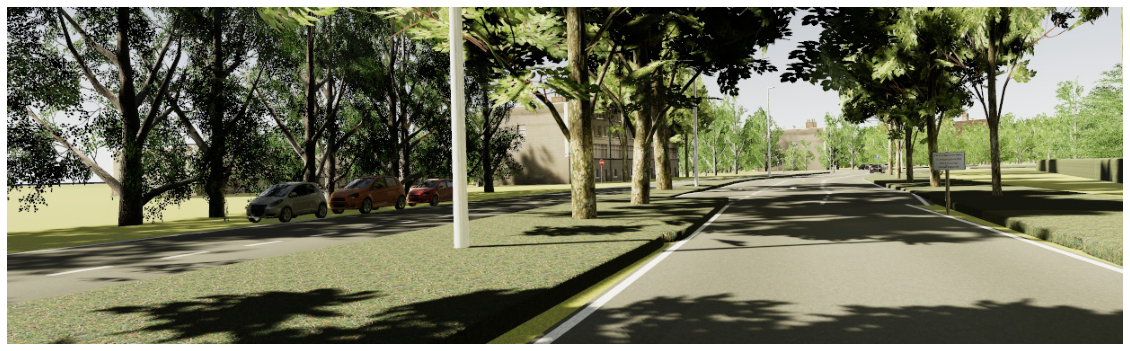

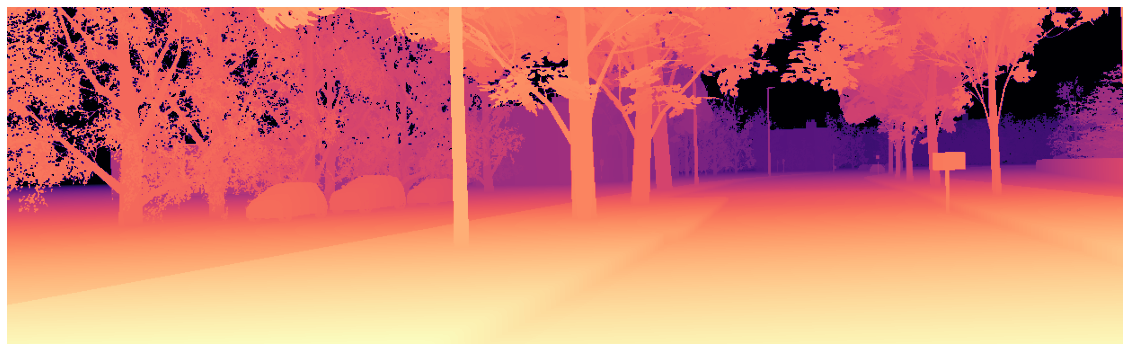

In [5]:
# Data
VKITTI_DIR = "../data/vkitti"
KITTI_DIR = "../data/kitti"
DATASET_LIMIT = None

kitti_train_dataset = KittiDepthDataset(KITTI_DIR, transform=train_transform, subset="train")
kitti_val_dataset = KittiDepthDataset(KITTI_DIR, transform=val_transform, subset="test")
test_dataset = KittiDepthDataset(KITTI_DIR, transform=val_transform, subset="test")
sample = kitti_train_dataset.get(0, transform=False)
show_sample(**sample)

vkitti_train_dataset = VkittiImageDataset(VKITTI_DIR, scenes=["Scene02", "Scene06", "Scene18", "Scene20"], subsets=("rgb", "depth"), transform=train_transform)
vkitti_val_dataset = VkittiImageDataset(VKITTI_DIR, scenes=["Scene01"], subsets=("rgb", "depth"), transform=val_transform)
sample = vkitti_train_dataset.get(0, transform=False)
show_sample(rgb=sample["rgb"], depth=sample["depth"])


# Mixed datasets
train_virtual_100 = vkitti_train_dataset

# Instantiate Model

In [6]:
model = DepthEstimator()

### *Optionally* load model parameters from disk

In [7]:
MODEL_PATH = "../models/100-virtual-0-real.pt"
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

# Train Model

In [ ]:
SHUFFLE = True
BATCH_SIZE = 8

train_dataloader = DataLoader(kitti_train_dataset, shuffle=SHUFFLE, batch_size=BATCH_SIZE, num_workers=BATCH_SIZE, pin_memory=True)
val_dataloader = DataLoader(kitti_val_dataset, shuffle=SHUFFLE, batch_size=BATCH_SIZE, num_workers=BATCH_SIZE, pin_memory=True)

logger = TestTubeLogger(save_dir="experiments/")
trainer = pl.Trainer(progress_bar_refresh_rate=1, gpus=[0], logger=logger)
trainer.fit(model, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)

# Visualize Prediction on Val Dataset

In [ ]:
def convert_model_output(depth_tensor, as_pil=False):
    depth_tensor = depth_tensor[0, 0] * 65535
    depth_tensor = depth_tensor.cpu().detach().numpy().round().astype(np.uint32)
    depth = Image.fromarray(depth_tensor) if as_pil else depth_tensor
    return depth

# Choose image index from val dataset
INDEX = 0
model.eval()

# Untransformed data
sample = kitti_val_dataset.get(INDEX, transform=False)
rgb = sample["rgb"]
depth = sample["depth"]

# Data transformed for input to model
sample_tensor = kitti_val_dataset[INDEX]
rgb_tensor = sample_tensor["rgb"]

predicted_depth_tensor = model(rgb_tensor.unsqueeze(0).cuda())
predicted_depth_tensor = F.interpolate(predicted_depth_tensor, size=rgb_tensor.shape[1:3])
predicted_depth = convert_model_output(predicted_depth_tensor)

show_sample(rgb=rgb)
show_sample(depth=depth)
show_sample(depth=predicted_depth)

sns.distplot(sample["depth"])
plt.show()
sns.distplot(predicted_depth)
plt.show()

# Optionally Save Model

In [ ]:
MODEL_PATH = "../models/0-virtual-100-real.pt"
torch.save(model.state_dict(), MODEL_PATH)

# Evalute on Test Dataset

In [ ]:
# Source: https://github.com/mrharicot/monodepth
def compute_errors(gt, pred):
    thresh = np.maximum(
        (gt / pred),
        (pred / gt)
    )
    a1 = (thresh < 1.25   ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()
    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())
    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())
    abs_rel = np.mean(np.abs(gt - pred) / gt)
    sq_rel = np.mean(((gt - pred)**2) / gt)
    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3


# TODO: replace with Real KITTI dataset
test_dataset = VkittiImageDataset(VKITTI_DIR, scenes=["Scene01"], subsets=("rgb", "depth"), transform=vkitti_val_transform)

all_errors = []
for i in range(len(test_dataset)):
    sample = test_dataset.get(i, transform=False)
    rgb = sample["rgb"]
    depth = sample["depth"]

    sample_tensor = test_dataset[i]
    rgb_tensor = sample_tensor["rgb"]
    depth_tensor = sample_tensor["depth"]

    predicted_depth_tensor = model(rgb_tensor.unsqueeze(0).cuda())
    predicted_depth_tensor = F.interpolate(predicted_depth_tensor, size=depth.size[::-1])
    predicted_depth = convert_model_output(predicted_depth_tensor)

#     show_sample(depth=depth)
#     show_sample(depth=predicted_depth)

    errors = compute_errors(np.array(depth), predicted_depth)
    all_errors.append(errors)

all_errors = np.array(all_errors)

In [ ]:
metric_names = ["abs_rel", "sq_rel", "rmse", "rmse_log", "a1", "a2", "a3"]
metrics = all_errors.mean(axis=0).tolist()
print(dict(zip(metric_names, metrics)))